In [1]:
# Use gammaln for stability
%matplotlib inline
# import matplotlib
# matplotlib.use('Agg')

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import time
from scipy import linalg
from scipy.io import loadmat
from scipy.misc import logsumexp
from scipy.special import digamma, gammaln, multigammaln
from scipy.stats import multivariate_normal, wishart
from sklearn.covariance import empirical_covariance

In [2]:
# # Load training data
# with np.load('train_data.npz', 'rb') as data:
#     X = data['train_encoded'].T[:, :1000]
    
# # Load test data
with np.load('lowdim.npz', 'rb') as data:
    X = data['test_encoded'].T

# # Sanity Check
# data = loadmat('hw4_data_mat/data.mat')
# X = data['X']

d = X.shape[0]
num = X.shape[1]
np.random.seed(3950)
print d
print num

# Centre the points
mean_X = np.mean(X, axis=1)
std_X = np.std(X, axis=1)
X = ((X.T - mean_X)/std_X).T

32
10000


In [3]:
# Set prior parameters
c_0 = 1
m_0 = 0
a_0 = d

# Calculate empirical covariance
A = empirical_covariance(X.T)
# A = empirical_covariance(train_X[0].T)
B_0 = 0.05 * A

In [4]:
def fix_slogdet(slogdet_out):
    if slogdet_out[0] == 0:
        return 1e-16
    else:
        return slogdet_out[0] * slogdet_out[1]

In [5]:
def fix_nans(x):
    if np.isnan(x):
        return 0
    else:
        return x

In [6]:
# t1 of q(c)
def t1(a_j, B_j, k):
    t1_1 = sum(map(lambda k: digamma(0.5 * (1 - k + a_j)), range(1, d+1)))
    t1_2 = fix_slogdet(np.linalg.slogdet(B_j))
    return t1_1 - t1_2

In [7]:
# t2 of q(c)
def t2(X, idx, m_j, a_j, pinv_B_j):
    return np.dot(np.dot((X[:, idx] - m_j).T, a_j * pinv_B_j), (X[:, idx] - m_j))

In [8]:
# t3 of q(c)
def t3(a_j, pinv_B_j, Sigma_j):
    return np.trace(np.dot(a_j * pinv_B_j, Sigma_j))

In [9]:
# t4 of q(c)
def t4(alpha, i):
    return digamma(alpha[i]) - digamma(sum(alpha))

In [10]:
def update_q_c(X, alpha, m, Sigma, a, B, k):
    q_c = np.empty((k ,num))
    # Calculate pseudoinverse separately as reusuable
    pinv_B = map(lambda i: linalg.pinv2(B[i]), range(k))
    for i in range(k): 
        # Calculate t1, t3, t4 first as reusable
        q_t1 = t1(a[i], B[i], k)
        q_t3 = t3(a[i], pinv_B[i], Sigma[i])
        q_t4 = t4(alpha, i)
        q_c[i, :] = map(lambda j: 0.5 * (q_t1 - t2(X, j, m[i], a[i], pinv_B[i]) - q_t3) + q_t4, range(num))
    for j in range(num):
        q_c[:, j] = np.exp(q_c[:, j] - logsumexp(q_c[:, j]))
    return q_c, pinv_B

In [11]:
def cal_n(q_c):
    # Returns a k-length vector
    return np.sum(q_c, axis=1)

In [12]:
def update_q_pi(alpha_0, n):
    return alpha_0 + n

In [13]:
def update_q_mu(X, c_0, n, a, pinv_B, q_c, k):
    Sigma = map(lambda j: linalg.pinv2(1.0/c_0 * np.identity(d) + n[j]*a[j]*pinv_B[j]), range(k))
    m = map(lambda j: np.dot(Sigma[j], a[j]*np.dot(pinv_B[j], np.dot(X, q_c[j, :].T))), range(k))
    return Sigma, m

In [14]:
def update_q_lambda(X, a_0, n, B, B_0, m, Sigma, q_c, k):
    a = a_0 + n
    x_minus_m = []
    for i in range(k):
        x_minus_m.append(X.T - m[i])
    for i in range(k):
        B_2 = sum(map(lambda j: q_c[i, j] * (np.dot(x_minus_m[i][j].reshape((d, 1)), x_minus_m[i][j].reshape((1, d))) + Sigma[i]), range(num)))
        B[i] = B_0 + B_2
    return a, B

In [15]:
def cal_E_ln_p_x_i_mu_j_lambda_j(X, E_ln_lambda_j, E_lambda_j, m_j, Sigma_j):
    x_minus_m = X.T - m_j
    E_x_m_T_lambda_x_m = map(lambda i: -np.dot(np.dot(x_minus_m[i].reshape((1, d)), E_lambda_j), x_minus_m[i].reshape((d, 1))), range(num))
    E_x_m_T_lambda_x_m -= np.trace(np.dot(E_lambda_j, Sigma_j))
    return np.array(0.5 * E_x_m_T_lambda_x_m + 0.5 * E_ln_lambda_j).reshape((num))

In [16]:
def cal_E_ln_pi(alpha, k):
    return map(lambda i: digamma(alpha[i]) - digamma(sum(alpha)), range(k))

In [17]:
def cal_L1(X, alpha, E_ln_lambda, E_lambda, m, Sigma, c, k):
    t2 = np.empty((k, num))
    for i in range(k):
        t2[i, :] = cal_E_ln_p_x_i_mu_j_lambda_j(X, E_ln_lambda[i], E_lambda[i], m[i], Sigma[i])
    t3 = np.array(cal_E_ln_pi(alpha, k)).reshape((1, k)) 
    t23 = t2 + t3.T
    L1 = 0
    for j in range(num):
        L1 += sum(map(lambda i: c[i, j] * t23[i, j], range(k)))
    return L1

In [18]:
def cal_E_ln_lambda(a, B, k):
    E_ln_lambda = []
    for i in range(k):
        t1 = fix_slogdet(np.linalg.slogdet(B[i]))
        t2 = sum(map(lambda j: digamma(0.5 * (a[i] + 1 - j)), range(1, d+1)))
        E_ln_lambda.append(-t1 + t2)
    return E_ln_lambda

In [19]:
def cal_E_lambda(a, B):
    return map(lambda a_B: a_B[0] * linalg.pinv2(a_B[1]), zip(a, B))

In [20]:
def cal_E_ln_p_mu(m):
    return map(lambda mu: -0.5*(np.dot(np.dot(mu.reshape((1, d)), 1/float(c_0) * np.identity(d)), mu.reshape((d, 1)))), m)

In [21]:
def cal_E_ln_p_lambda(E_ln_lambda, E_lambda, B_0):
    return map(lambda lbda: -0.5*(lbda[0] + np.trace(np.dot(B_0, lbda[1]))), zip(E_ln_lambda, E_lambda))

In [22]:
def cal_L2(E_ln_p_mu, E_ln_p_lambda):
    return sum(E_ln_p_mu + E_ln_p_lambda)

In [23]:
def cal_L3(c, k):
    L3 = 0
    for j in range(num):
        # print (map(lambda i: c[i, j], range(k)))
        L3 += sum(map(lambda i: fix_nans(c[i, j] * np.log(c[i, j])), range(k)))
    return L3

In [24]:
def cal_L4(alpha, k):
    sum_alpha = sum(alpha)
    t1 = sum(map(lambda i: gammaln(alpha[i]), range(k)))
    t2 = gammaln(sum_alpha)
    t3 = (k - sum_alpha) * digamma(sum_alpha)
    t4 = sum(map(lambda i: (alpha[i]-1) * digamma(alpha[i]), range(k)))
    return t1 - t2 - t3 - t4

In [25]:
def cal_L5(Sigma, k):
    log_det = map(lambda i: fix_slogdet(np.linalg.slogdet(2 * np.pi * np.exp(1) * Sigma[i])), range(k))
    return 0.5 * sum(log_det)

In [26]:
def cal_L6(a, B, E_ln_lambda, E_lambda, k):
    log_det = map(lambda i: fix_slogdet(np.linalg.slogdet(B[i])), range(k))
    return sum(map(lambda i: -0.5 * a[i] * log_det[i] + 0.5 * a[i] * d * np.log(2) + multigammaln(a[i]/2, d) - 0.5 * (a[i] - d - 1) *  E_ln_lambda[i] - np.trace(np.dot(B[i], E_lambda[i])), range(k)))

In [27]:
def VI(X, k):
    # Initialise variables
    alpha_0 = np.ones(k)
    alpha = alpha_0
    m = [np.random.uniform(-1, 1, d) for i in range(k)]
    Sigma = [c_0 * np.identity(d)] * k
    a = [a_0] * k
    B = [B_0] * k
    L = []
    
    # Run VI
    for i in range(150):
        start_time = time.time()
        # Update hyperparameters
        c, pinv_B = update_q_c(X, alpha, m, Sigma, a, B, k)
        update_c_time = time.time()
        n = cal_n(c)
        # print a
        # print n
        alpha = update_q_pi(alpha_0, n)
        update_alpha_time = time.time()
        Sigma, m = update_q_mu(X, c_0, n, a, pinv_B, c, k)
        update_mu_time = time.time()
        a, B = update_q_lambda(X, a_0, n, B, B_0, m, Sigma, c, k)
        update_lambda_time = time.time()
        
        # Calculate likelihood
        E_ln_lambda = cal_E_ln_lambda(a, B, k)
        E_lambda = cal_E_lambda(a, B)
        L1 = cal_L1(X, alpha, E_ln_lambda, E_lambda, m, Sigma, c, k)
        E_ln_p_mu = cal_E_ln_p_mu(m)
        E_ln_p_lambda = cal_E_ln_p_lambda(E_ln_lambda, E_lambda, B_0)
        L2 = cal_L2(E_ln_p_mu, E_ln_p_lambda)
        L3 = cal_L3(c, k)
        L4 = cal_L4(alpha, k)
        L5 = cal_L5(Sigma, k)
        L6 = cal_L6(a, B, E_ln_lambda, E_lambda, k)
        LL = L1 + L2 - L3 + L4 + L5 + L6
        L.append(LL.flatten()[0])
        end_time = time.time()
    
        print 'Iteration ' + str(i), (end_time - update_lambda_time), (update_lambda_time - update_mu_time), (update_mu_time - update_alpha_time), (update_alpha_time - update_c_time), (update_c_time - start_time)
    
    s = map(lambda i: B[i]/float(a[i]), range(k))
    return L, c, m, s

In [28]:
def plot_clusters(X, c, k, num):
    cluster = {}
    for i in range(k):
        cluster[i] = [[], []]
    for i in range(num):
        assignment = np.argmax(c[:, i])
        cluster[assignment][0].append(X[2:4, i][0])
        cluster[assignment][1].append(X[2:4, i][1])
    color = iter(plt.cm.rainbow(np.linspace(0,1,k)))
    for i in range(k):
        plt.scatter(cluster[i][0], cluster[i][1], label='Cluster_' + str(i), c=next(color), marker='o')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Plot of Clusters (K = ' + str(k) + ')')

In [29]:
# Done on server
# L_10, c_10, m_10, s_10 = VI(X, 10)
# plt.plot(range(150), L_10)
# plt.xlabel('Iterations')
# plt.ylabel('Variational Objective Function')
# plt.title('Variational Objective Function against Iterations (K = 10)')
# plt.savefig('VI.png')

In [30]:
Run_1 = np.load('E_mu_sigma_Run_1.npz', 'rb')

In [31]:
mu = Run_1['mu']
sigma = Run_1['sigma']

In [32]:
assignments = np.zeros((10, num))
for i in range(10):
    assignments[i, :] = map(lambda j: multivariate_normal.logpdf(X[:, j], mu[i], sigma[i]), range(num))

In [33]:
test_labels = np.load('Test_Labels.npy')

In [34]:
pred_label = {}
for i in range(num):
    try:
        pred_label[np.argmax(assignments[:, i])].append(i)
    except KeyError:
        pred_label[np.argmax(assignments[:, i])] = [i]

In [36]:
true_label = {}
for i in range(num):
    try:
        true_label[np.argmax(test_labels[i, :])].append(i)
    except KeyError:
        true_label[np.argmax(test_labels[i, :])] = [i]

In [43]:
# label_matrix = np.empty((10, 10))
# for j in true_label.keys():
#     true_set = set(true_label[j])
#     for i in pred_label.keys():
#         pred_set = set(pred_label[i])
#         label_matrix[j, i] = len(pred_set.intersection(true_set))
# x = label_matrix[[False, False, False, False, False, True, False, False, True, False], :][:, [False, False, False, False, False, False, False, True, False, False]]
# print np.max(x)
# print x

In [44]:
# np.set_printoptions(linewidth=150)
# print label_matrix

In [45]:
# sum(sum(label_matrix[[range(10)], [1, 2, 4, 8, 3, 7, 6, 9, 5, 0]]))

In [40]:
pred_assignments = []
labels = []
for i in range(num):
    pred_assignments.append(np.argmax(assignments[:, i]))
    labels.append(np.argmax(test_labels[i, :]))

In [41]:
def plot_dist(assignments, labels):
    f, a = plt.subplots(2, 5, figsize=(12, 5))
    for i in range(10):
        dist = labels[np.where(assignments == i)]
        j = i / 5
        k = i % 5
        a[j][k].set_ylim([0, 1000])
        a[j][k].set_xlim([0, 10])
        a[j][k].hist(dist)
    for array in a:
        for subplots in array:
            subplots.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()

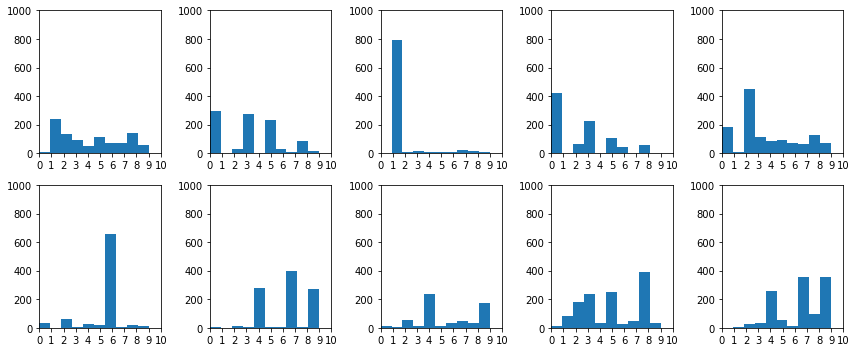

In [42]:
plot_dist(np.array(pred_assignments), np.array(labels))